In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import RocCurveDisplay, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from xgboost import XGBClassifier

from tools_ml.data_process import filter_features
from tools_ml.models import get_pipeline

In [4]:
df_raw = pd.read_csv("data/application_train.csv")

# Dropando a coluna de gênero e SK_ID_CURR
df_raw.drop("CODE_GENDER", inplace=True, axis=1)
df_raw.drop("SK_ID_CURR", inplace=True, axis=1)

# Filtrando as features com mais de 50% de valores nulos
df_raw_fil = filter_features(df_raw, 0.5)

In [5]:
# Features Numéricas
features_num = df_raw_fil.select_dtypes(include=np.number).columns.tolist()
features_num.remove('TARGET')

# Features Categóricas
features_cat = df_raw_fil.select_dtypes(exclude=np.number).columns.tolist()

# Selecionando features que possuem menos de 10 categorias
df_num = df_raw_fil[features_num]
novas_cat = df_num.nunique()[df_num.nunique()<10].sort_values()
novas_cat.drop([
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK'
], inplace=True)

features_cat = features_cat + novas_cat.index.tolist()
features_num = df_raw_fil.columns.drop(features_cat).tolist()
features_num.remove('TARGET')

In [6]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df_raw_fil.drop(columns='TARGET'),
    df_raw_fil['TARGET'],
    train_size=0.7,
    random_state=42,
    stratify=df_raw_fil['TARGET']
)

In [7]:
# Proporção entre 0 e 1 na variável alvo
ratio = y_train.value_counts()[0]/y_train.value_counts()[1]

pipe_final = get_pipeline(
    features_cat=features_cat,
    features_num=features_num,
    classifier=XGBClassifier(random_state=42, scale_pos_weight=ratio)
)

In [8]:
# Hyperparam tuning
espaco_hiper = {
    'classifier__learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'classifier__max_depth' : [3, 4, 5, 6, 8, 10, 12, 15],
    'classifier__min_child_weight' : [1, 3, 5, 7 ],
    'classifier__gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
    'classifier__colsample_bytree' : [0.3, 0.4, 0.5 , 0.7]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rand_xgb = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=espaco_hiper,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-2,
    verbose=5,
    random_state=42
)

rand_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('pre_processor',
                                              ColumnTransformer(transformers=[('tr_num',
                                                                               Pipeline(steps=[('tr_imput_mean',
                                                                                                SimpleImputer()),
                                                                                               ('tr_min_max',
                                                                                                StandardScaler())]),
                                                                               ['CNT_CHILDREN',
                                                                                'AMT_INCOME_TOTAL',
                                                                                'AMT_CREDIT',
                      

In [9]:
# Getting predictions
y_pred = rand_xgb.predict(X_test)

c:\Users\Guilerme\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [10]:
# Model report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     67812
           1       0.17      0.66      0.27      5991

    accuracy                           0.70     73803
   macro avg       0.56      0.68      0.54     73803
weighted avg       0.89      0.70      0.77     73803



In [11]:
df_report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(df_report).transpose()
df_report

,precision,recall,f1-score,support
0,0.959146,0.707662,0.814433,67812.000000
1,0.166043,0.658822,0.265238,5991.000000
accuracy,0.703698,0.703698,0.703698,0.703698
macro avg,0.562594,0.683242,0.539835,73803.000000
weighted avg,0.894766,0.703698,0.769851,73803.000000


In [12]:
# Params and Score
print("Best Parameters:")
for param, value in rand_xgb.best_params_.items():
    print(f"  - {param.title()}: {value:.2g}")
print(f"Best Score: {rand_xgb.best_score_:.2g}") 

Best Parameters:
  - Classifier__Min_Child_Weight: 5
  - Classifier__Max_Depth: 4
  - Classifier__Learning_Rate: 0.2
  - Classifier__Gamma: 0.3
  - Classifier__Colsample_Bytree: 0.4
Best Score: 0.74


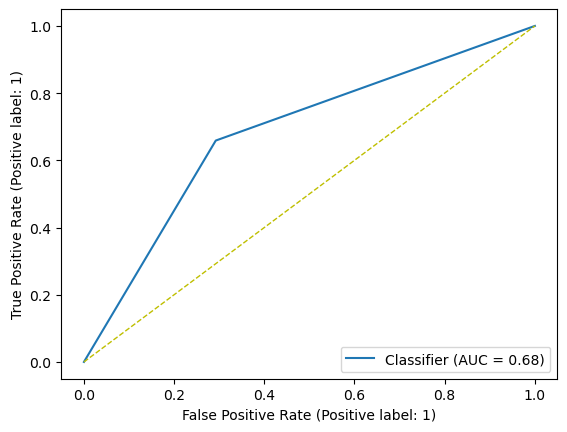

In [16]:
# Roc Curve
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.plot([0,1], [0,1], '--', color = 'y', linewidth= 1)
plt.show()